In [ ]:
# https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install mtcnn
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
import os
from os import listdir
from os.path import isdir
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
import mtcnn
from mtcnn.mtcnn import MTCNN

In [3]:
os.chdir('/content/drive/My Drive/final_project')

In [4]:
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [ ]:
# load image from file
filename = "person.jpeg"
image = Image.open(filename)
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = np.asarray(image)

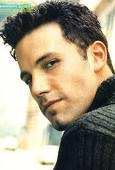

In [ ]:
image

In [ ]:
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)

In [ ]:
# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']
# bug fix
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height
# extract the face
face = pixels[y1:y2, x1:x2]

# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((160, 160))
face_array = np.asarray(image)

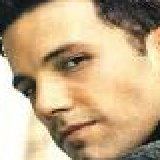

In [ ]:
image

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


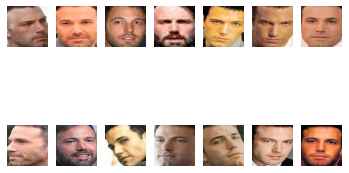

In [5]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = np.asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = np.asarray(image)
	return face_array
 
# specify folder to plot
folder = '5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	plt.subplot(2, 7, i)
	plt.axis('off')
	plt.imshow(face)
	i += 1
plt.show()

In [6]:
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [7]:
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return np.asarray(X), np.asarray(y)


In [8]:
def load_image(filename, label):
  X, y = list(), list()
  # load all faces in the subdirectory
  faces = extract_face(filename)
  # create labels
  labels = [label]
  # store
  X.extend([faces])
  y.extend(labels)
  return np.asarray(X), np.asarray(y)

In [11]:
# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
>loaded 17 examples for class: elton_john
>loaded 19 examples for class: madonna
>loaded 14 examples for class: ben_afflek
>loaded 9 examples for class: gary
(102, 160, 160, 3) (102,)
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: ben_afflek
>loaded 4 examples for class: gary
(29, 160, 160, 3) (29,)


In [9]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = np.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (102, 160, 160, 3) (102,) (29, 160, 160, 3) (29,)
Loaded Model
(102, 128)
(29, 128)


In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = np.load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=102, test=29
Accuracy: train=100.000, test=93.103


In [10]:
from random import choice
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load faces
data = np.load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = np.load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
for i in range(testX.shape[0]):
  selection = testX.shape[0] - i - 1
  random_face_pixels = testX_faces[selection]
  random_face_emb = testX[selection]
  random_face_class = testy[selection]
  random_face_name = out_encoder.inverse_transform([random_face_class])
  # prediction for the face
  samples = np.expand_dims(random_face_emb, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
  # get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
  print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
  print('Expected: %s' % random_face_name[0])
  # print(yhat_class)
  # print(yhat_prob)
  # plot for fun
  # plt.imshow(random_face_pixels)
  # title = '%s (%.3f)' % (predict_names[0], class_probability)
  # plt.title(title)
  # plt.show()

Predicted: mindy_kaling (41.701)
Expected: gary
Predicted: elton_john (27.687)
Expected: gary
Predicted: gary (70.855)
Expected: gary
Predicted: gary (73.984)
Expected: gary
Predicted: ben_afflek (86.427)
Expected: ben_afflek
Predicted: ben_afflek (87.175)
Expected: ben_afflek
Predicted: ben_afflek (86.313)
Expected: ben_afflek
Predicted: ben_afflek (69.043)
Expected: ben_afflek
Predicted: ben_afflek (82.758)
Expected: ben_afflek
Predicted: elton_john (88.652)
Expected: elton_john
Predicted: elton_john (85.989)
Expected: elton_john
Predicted: elton_john (85.967)
Expected: elton_john
Predicted: elton_john (87.204)
Expected: elton_john
Predicted: elton_john (89.875)
Expected: elton_john
Predicted: jerry_seinfeld (69.895)
Expected: jerry_seinfeld
Predicted: jerry_seinfeld (81.921)
Expected: jerry_seinfeld
Predicted: jerry_seinfeld (83.975)
Expected: jerry_seinfeld
Predicted: jerry_seinfeld (86.703)
Expected: jerry_seinfeld
Predicted: jerry_seinfeld (85.691)
Expected: jerry_seinfeld
Predic

In [16]:
test_image, fake_label = load_image('5-celebrity-faces-dataset/val/gary/ali_wong.jpg', 'gary')

In [17]:
model2 = load_model('facenet_keras.h5')

In [18]:
embedding = np.array([get_embedding(model2, test_image[0])])

Predicted: unknown (40.847)
Expected: gary
[5]
[[0.11523554 0.25248202 0.05924204 0.08988528 0.07468445 0.40847067]]


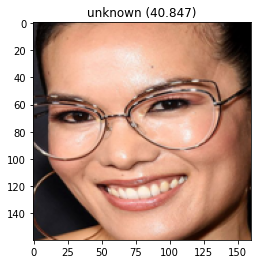

In [20]:
norm_embedding = in_encoder.transform(embedding)
# label encode targets
target_label = out_encoder.transform(fake_label)
random_face_pixels = test_image[0]
random_face_emb = norm_embedding[0]
random_face_class = target_label[0]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
if class_probability < 70:
  predict_names[0] = 'unknown'
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
print(yhat_class)
print(yhat_prob)
# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

In [11]:
from joblib import dump, load
dump(model, 'face_classifier.joblib') 

['face_classifier.joblib']

In [15]:
model = load('face_classifier.joblib')

In [24]:
np.save('classes.npy', out_encoder.classes_)
